# **A2C Algorithm (Stable Baseline3)**

Use Stable Baselines3 to train an Advantage Actor-Critic (A2C) agent on the MountainCar-v0 environment.

1. **Visualize A2C Algorithm**:
Visualization of the A2C algorithm's architecture using Graphviz.

2. **Install Dependencies**:
Install required packages for reinforcement learning, environment simulation, and visualization.

3. **Import Libraries**:
Import essential libraries for model training, hyperparameter tuning, and video processing.

4. **Define Helper Functions and Custom Callbacks**:
Define functions and callbacks for rendering frames, creating animations, and logging rewards and videos.

5. **Set Up the Environment**:
Initialize and configure the MountainCar-v0 environment for training and evaluation.

6. **Define Optuna Optimization Function**:
Create a function to optimize hyperparameters using Optuna.

7. **Run Optuna Study**:
Perform hyperparameter optimization with Optuna and print the best hyperparameters.

8. **Train the Final Model with Best Hyperparameters**:
Train the A2C model using the best hyperparameters found and save the training video.

9. **Evaluate the Model and Capture Evaluation Frames**:
Evaluate the trained model, capture frames, and save the evaluation video.

10. **Plot Rewards of Training**:
Plot and visualize the rewards obtained during training.

11. **Display Training and Evaluation Videos and Provide Download Links**:
Display and provide download links for both the training and evaluation videos.

# Visualize A2C Algorithm

A2C Algorithm block diagram created successfully!


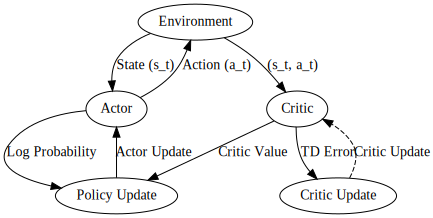

In [80]:
# Visualize A2C Algorithm
import graphviz
graphviz.__version__, graphviz.version()
from graphviz import Digraph

# Define the graph
dot = Digraph(name='A2C_Algorithm', format='png')

# Add nodes
dot.node('environment', label='Environment')
dot.node('actor', label='Actor')
dot.node('critic', label='Critic')
dot.node('policy_update', label='Policy Update')
dot.node('critic_update', label='Critic Update')

# Add edges with labels
dot.edge('environment', 'actor', label='State (s_t)')
dot.edge('actor', 'environment', label='Action (a_t)')
dot.edge('environment', 'critic', label='(s_t, a_t)')
dot.edge('critic', 'policy_update', label='Critic Value')
dot.edge('actor', 'policy_update', label='Log Probability')
dot.edge('policy_update', 'actor', label='Actor Update')
dot.edge('critic', 'critic_update', label='TD Error')
dot.edge('critic_update', 'critic', label='Critic Update', style='dashed')

# Render the graph
dot.render('a2c_diagram.png', view=True)

print("A2C Algorithm block diagram created successfully!")

dot

The **A2C (Advantage Actor-Critic)** algorithm diagram visually represents the key components and data flow involved in the A2C reinforcement learning algorithm. Here’s a summary of the diagram's components and their interactions:

**Environment**: The environment interacts with the agent by providing states and rewards. It receives actions from the Actor and sends state-action pairs to the Critic.

**Actor**: The Actor network decides which action to take based on the current state. It receives the state from the environment and sends the chosen action back. The Actor also receives updates from the Policy Update step to improve its policy.

**Critic**: The Critic network estimates the value of states or state-action pairs. It receives state-action pairs from the environment and provides value estimates to the Policy Update step. The Critic is updated based on the TD (temporal difference) error.

**Policy Update**: This step updates the Actor based on the computed advantage function, which measures how good the taken actions are relative to the estimated values. The Policy Update step adjusts the Actor’s policy to maximize rewards.

**Critic Update**: This step refines the Critic’s value function based on the TD error, which is the difference between the predicted value and the actual reward plus the discounted value of the next state.

**Data Flow**:

The Environment sends the state to the Actor and receives actions from it.

The Actor provides actions to the Environment and logs probabilities of those actions.

The Environment provides state-action pairs to the Critic for value estimation.

The Critic calculates the TD error and provides value estimates to the Policy Update step.

The Policy Update step uses the advantage function and the Actor’s log probabilities to update the Actor.

The Critic is updated based on the TD error received from the Critic Update step.

The diagram encapsulates the iterative process of updating both the Actor and Critic networks to optimize the policy and value function for improved decision-making in reinforcement learning.

# Install Dependencies

In [81]:
# Summary:
# Install the required Python packages for Stable Baselines3, Gym, Matplotlib, ACME, and Optuna.

!pip install --upgrade stable-baselines3 gymnasium matplotlib optuna


# Import Libraries

In [82]:
# Summary:
# Import necessary libraries for reinforcement learning, hyperparameter tuning, and visualization.

import numpy as np
import gym
import matplotlib.pyplot as plt
from gymnasium.wrappers import StepAPICompatibility
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from matplotlib import animation
from IPython.display import display, HTML
import cv2
from base64 import b64encode
import pandas as pd
import optuna

# Helper Functions and Custom Callbacks

In [83]:
# Summary:
# Define helper functions and custom callbacks for video rendering and reward logging.

def display_video(video_path):
    """Display a video in a Jupyter Notebook from a given file path."""
    with open(video_path, 'rb') as f:
        video_data = f.read()
    video_base64 = b64encode(video_data).decode()
    video_html = f"""
    <video width="600" controls>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
    """
    display(HTML(video_html))

class VideoCallback(BaseCallback):
    """Custom callback to save video frames during training."""
    def __init__(self, save_path, env, freq=1000, verbose=1):
        super().__init__(verbose)
        self.save_path = save_path
        self.env = env
        self.freq = freq
        self.frames = []
        self.frame_counter = 0

    def _on_step(self) -> bool:
        self.frame_counter += 1
        if self.frame_counter % self.freq == 0:
            frame = self.env.render(mode='rgb_array')
            self.frames.append(frame)
        return True

    def _on_training_end(self):
        if self.frames:
            height, width, _ = self.frames[0].shape
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            video = cv2.VideoWriter(self.save_path, fourcc, 30.0, (width, height))
            for frame in self.frames:
                video.write(frame)
            video.release()

class RewardLoggerCallback(BaseCallback):
    """Custom callback to log rewards during training."""
    def __init__(self, log_path, verbose=1):
        super().__init__(verbose)
        self.log_path = log_path
        self.rewards = []

    def _on_step(self) -> bool:
        if self.n_calls % 1000 == 0:  # Log every 1000 steps
            infos = self.locals.get('infos', [])
            if infos:
                for info in infos:
                    reward = info.get('reward', None)
                    if reward is not None:
                        self.rewards.append(reward)
                    else:
                        print(f"Reward not found in info: {info}")
            else:
                print("Infos list is empty or not available.")
        return True

    def _on_training_end(self):
        pd.DataFrame(self.rewards, columns=["Reward"]).to_csv(self.log_path, index=False)

# Set Up the Environment

In [84]:
# Summary:
# Set up the MountainCar-v0 environment with RGB rendering, compatible with the newer API.

env = gym.make("MountainCar-v0", render_mode='rgb_array')
env = StepAPICompatibility(env)  # Ensure compatibility with the newer API
env = DummyVecEnv([lambda: env])

# Define Optuna Optimization Function

In [103]:
# Summary:
# Define an Optuna objective function for hyperparameter tuning, which trains the A2C model and evaluates its performance.

def objective(trial):
    """Optuna objective function to optimize hyperparameters for A2C."""
    n_steps = trial.suggest_categorical("n_steps", [5, 10, 20, 50])
    gamma = trial.suggest_float("gamma", 0.9, 0.999, log=True)
    gae_lambda = trial.suggest_float("gae_lambda", 0.8, 0.95, log=True)
    ent_coef = trial.suggest_float("ent_coef", 1e-5, 0.01, log=True)
    vf_coef = trial.suggest_float("vf_coef", 0.1, 1.0, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    env = gym.make("MountainCar-v0")
    env = DummyVecEnv([lambda: env])

    model = A2C("MlpPolicy", env, n_steps=n_steps, gamma=gamma, gae_lambda=gae_lambda,
                ent_coef=ent_coef, vf_coef=vf_coef, verbose=0, tensorboard_log="./a2c_mountaincar_tensorboard/")

    model.learn(total_timesteps=100000)

    total_reward = 0
    for _ in range(10):  # Evaluate over 10 episodes
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
    mean_reward = total_reward / 10

    return mean_reward


# Run Optuna Study

In [104]:
# Summary:
# Create and run an Optuna study to optimize the hyperparameters by running multiple trials.

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:")
print(study.best_params)


[I 2024-09-08 11:17:53,054] A new study created in memory with name: no-name-795ddaca-0908-442b-8c90-87f84ec8a929
[I 2024-09-08 11:19:37,264] Trial 0 finished with value: -200.0 and parameters: {'n_steps': 50, 'gamma': 0.9961412982423753, 'gae_lambda': 0.8800879540863525, 'ent_coef': 0.0002259026793098117, 'vf_coef': 0.34791043727917736, 'learning_rate': 0.003081053110594102}. Best is trial 0 with value: -200.0.
[I 2024-09-08 11:21:40,458] Trial 1 finished with value: -200.0 and parameters: {'n_steps': 20, 'gamma': 0.9420011259109179, 'gae_lambda': 0.9010611734880644, 'ent_coef': 0.002146202308699207, 'vf_coef': 0.8534847562023973, 'learning_rate': 0.0029354926669683925}. Best is trial 0 with value: -200.0.
[I 2024-09-08 11:23:43,037] Trial 2 finished with value: -200.0 and parameters: {'n_steps': 20, 'gamma': 0.9497015342948759, 'gae_lambda': 0.9384335722274537, 'ent_coef': 3.2494359676070914e-05, 'vf_coef': 0.17145925042715346, 'learning_rate': 0.0036702607929774917}. Best is trial 0

Best hyperparameters:
{'n_steps': 50, 'gamma': 0.9961412982423753, 'gae_lambda': 0.8800879540863525, 'ent_coef': 0.0002259026793098117, 'vf_coef': 0.34791043727917736, 'learning_rate': 0.003081053110594102}


# Train the Final Model with Best Hyperparameters

In [105]:
# Summary:
# Train the final A2C model using the best hyperparameters found by Optuna, and set up callbacks for video and reward logging.

!pip install gymnasium[classic_control]
import gymnasium as gym

best_params = study.best_params

env = gym.make("MountainCar-v0", render_mode='rgb_array')
env = StepAPICompatibility(env)
env = DummyVecEnv([lambda: env])

model = A2C("MlpPolicy", env, n_steps=best_params['n_steps'], gamma=best_params['gamma'],
            gae_lambda=best_params['gae_lambda'], ent_coef=best_params['ent_coef'],
            vf_coef=best_params['vf_coef'], verbose=1, tensorboard_log="./a2c_mountaincar_tensorboard/")

video_path = "training_video.mp4"
reward_log_path = "reward_log.csv"

video_callback = VideoCallback(save_path=video_path, env=env, freq=1000)
reward_logger_callback = RewardLoggerCallback(log_path=reward_log_path)

model.learn(total_timesteps=20000, callback=[video_callback, reward_logger_callback])


Using cpu device
Logging to ./a2c_mountaincar_tensorboard/A2C_108
Reward not found in info: {'TimeLimit.truncated': True, 'terminal_observation': array([-0.5290283 ,  0.00473623], dtype=float32)}
Reward not found in info: {'TimeLimit.truncated': True, 'terminal_observation': array([-0.48078936,  0.00145896], dtype=float32)}
Reward not found in info: {'TimeLimit.truncated': True, 'terminal_observation': array([-0.5900719 , -0.00887501], dtype=float32)}
Reward not found in info: {'TimeLimit.truncated': True, 'terminal_observation': array([-0.4946425 , -0.01364765], dtype=float32)}
Reward not found in info: {'TimeLimit.truncated': True, 'terminal_observation': array([-0.50299925,  0.02335755], dtype=float32)}
------------------------------------
| time/                 |          |
|    fps                | 1013     |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       |

# Evaluate the Model and Capture Evaluation Frames

In [92]:
# Summary:
# Define a value function for demonstration and generate frames for plotting an animation.

def value_function(state, weights):
    """Example value function for demonstration."""
    if state.ndim > 1:
        state = state.flatten()
    return np.dot(weights, state)

def render_frames(env, value_function, weights, max_steps=500):
    """Generate frames from the environment using the value function."""
    frames = []
    state = env.reset()
    done = False
    count = 0

    while not done:
        img = env.render()
        frames.append(img)
        # Calculate the value for each action and select the action with the highest value.

        # The original code was not providing an array of actions to env.step()
        # action = np.argmax([value_function(state, weights) for a in range(env.action_space.n)])

        # Get the action for the first (and only) environment
        action = np.argmax([value_function(state[0], weights) for a in range(env.action_space.n)])

        # Provide the action as a list
        # The original code was unpacking 5 values when only 4 were returned
        # state, reward, done, truncated, info = env.step([action])

        # Correctly unpack the 4 returned values
        state, reward, done, info = env.step([action])
        count += 1
        if count > max_steps:
            break

    env.close()
    return frames

def plot_animation(frames):
    """Plot and display animation."""
    fig, ax = plt.subplots()

    def update_scene(num, frames, patch):
        patch.set_data(frames[num])
        return patch

    def init():
        patch.set_data(frames[0])
        return patch,

    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                   frames=len(frames), init_func=init, interval=40, repeat=False)
    plt.close()
    return anim

# Example weights (for demonstration purposes)
n_actions = 3
n_features = 2
weights_1 = np.random.rand(n_actions, n_features)

# Generate frames and plot the animation
frames = render_frames(env, value_function, weights_1)
anim = plot_animation(frames)
HTML(anim.to_jshtml())

# Plot Rewards of Training

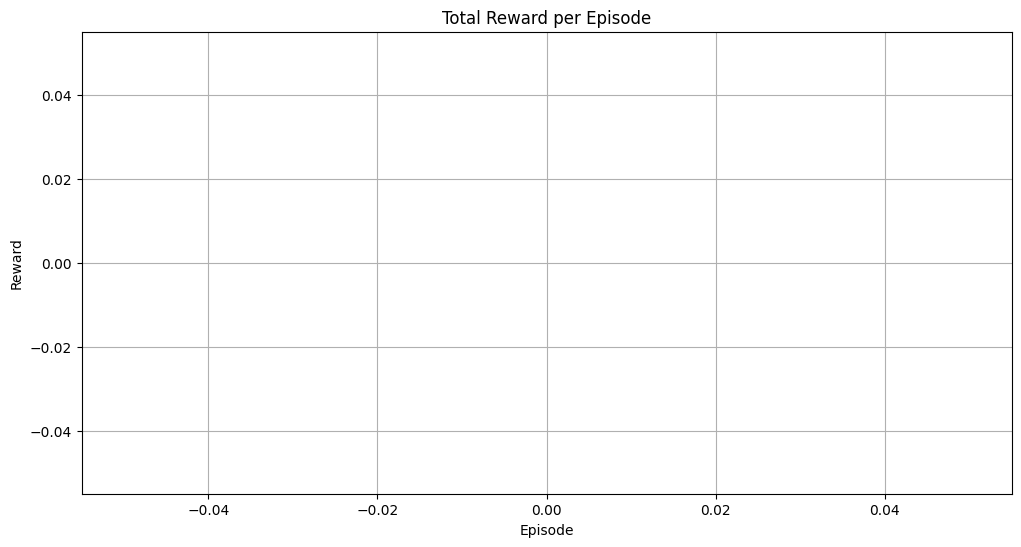

In [93]:
# Summary:
# Load the reward log data and plot the rewards obtained during the training process.

# Load the reward log data
reward_data = pd.read_csv(reward_log_path)

# Plot the rewards
plt.figure(figsize=(12, 6))
plt.plot(reward_data['Reward'])
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


# Display Training and Evaluation Videos and Provide Download Links

In [94]:
# Summary:
# Display the saved video of the training process and provide a download link for it.

# Display the saved video
display_video(video_path)

# Provide download link for the video
from google.colab import files
files.download(video_path)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>